In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\STPI0560\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\STPI0560\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\STPI0560\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\STPI0560\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\STPI0560\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
#https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [31]:
# Read in data
df = pd.read_csv('C:/Users/STPI0560/Desktop/Python Projects/neap_pilot/data/diary_entries.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(31, 1)
(31, 1)


In [32]:
df.head()

,Entry
0,"Good nights sleep, was a bit hot 🥵"
1,Very week and feeling tired after metformin Le...
2,Still grieving for mother who passed away in May
3,I had a great day today!
4,I’m tired!


In [33]:
df['ID'] = np.arange(len(df))

In [34]:
example = df['Entry'][1]
print(example)

Very week and feeling tired after metformin Level dropped dramatically late afternoon 


In [35]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Very',
 'week',
 'and',
 'feeling',
 'tired',
 'after',
 'metformin',
 'Level',
 'dropped',
 'dramatically']

In [36]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Very', 'RB'),
 ('week', 'NN'),
 ('and', 'CC'),
 ('feeling', 'NN'),
 ('tired', 'VBN'),
 ('after', 'IN'),
 ('metformin', 'JJ'),
 ('Level', 'NNP'),
 ('dropped', 'VBD'),
 ('dramatically', 'RB')]

In [37]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Very/RB
  week/NN
  and/CC
  feeling/NN
  tired/VBN
  after/IN
  metformin/JJ
  (PERSON Level/NNP)
  dropped/VBD
  dramatically/RB
  late/JJ
  afternoon/NN)


In [38]:



sia = SentimentIntensityAnalyzer()

In [39]:
sia.polarity_scores('I had a great day today!')

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [40]:
sia.polarity_scores('Still grieving for mother who passed away in May')

{'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'compound': -0.5106}

In [41]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Entry']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/31 [00:00<?, ?it/s]

In [42]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders = vaders.merge(df, how='left')

In [43]:
# Now we have sentiment score and metadata
vaders.head()

,ID,neg,neu,pos,compound,Entry
0,0,0.000,0.633,0.367,0.4404,"Good nights sleep, was a bit hot 🥵"
1,1,0.198,0.682,0.120,-0.2815,Very week and feeling tired after metformin Le...
2,2,0.292,0.708,0.000,-0.5106,Still grieving for mother who passed away in May
3,3,0.000,0.406,0.594,0.6588,I had a great day today!
4,4,0.761,0.239,0.000,-0.4926,I’m tired!


In [44]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from scipy.special import softmax
#from tensorflow import TFAutoModelForSequenceClassification

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [18]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Very week and feeling tired after metformin Level dropped dramatically late afternoon 


{'neg': 0.198, 'neu': 0.682, 'pos': 0.12, 'compound': -0.2815}

In [19]:
encoded_text = tokenizer(example, return_tensors='tf')
output = model(**encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(example)
print(scores_dict)

Very week and feeling tired after metformin Level dropped dramatically late afternoon 
{'roberta_neg': 0.886625, 'roberta_neu': 0.102958344, 'roberta_pos': 0.010416527}


In [20]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='tf')
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [21]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Entry']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/31 [00:00<?, ?it/s]

In [22]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
results_df = results_df.merge(df, how='left')

In [23]:
results_df.columns

Index(['ID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Entry'],
      dtype='object')

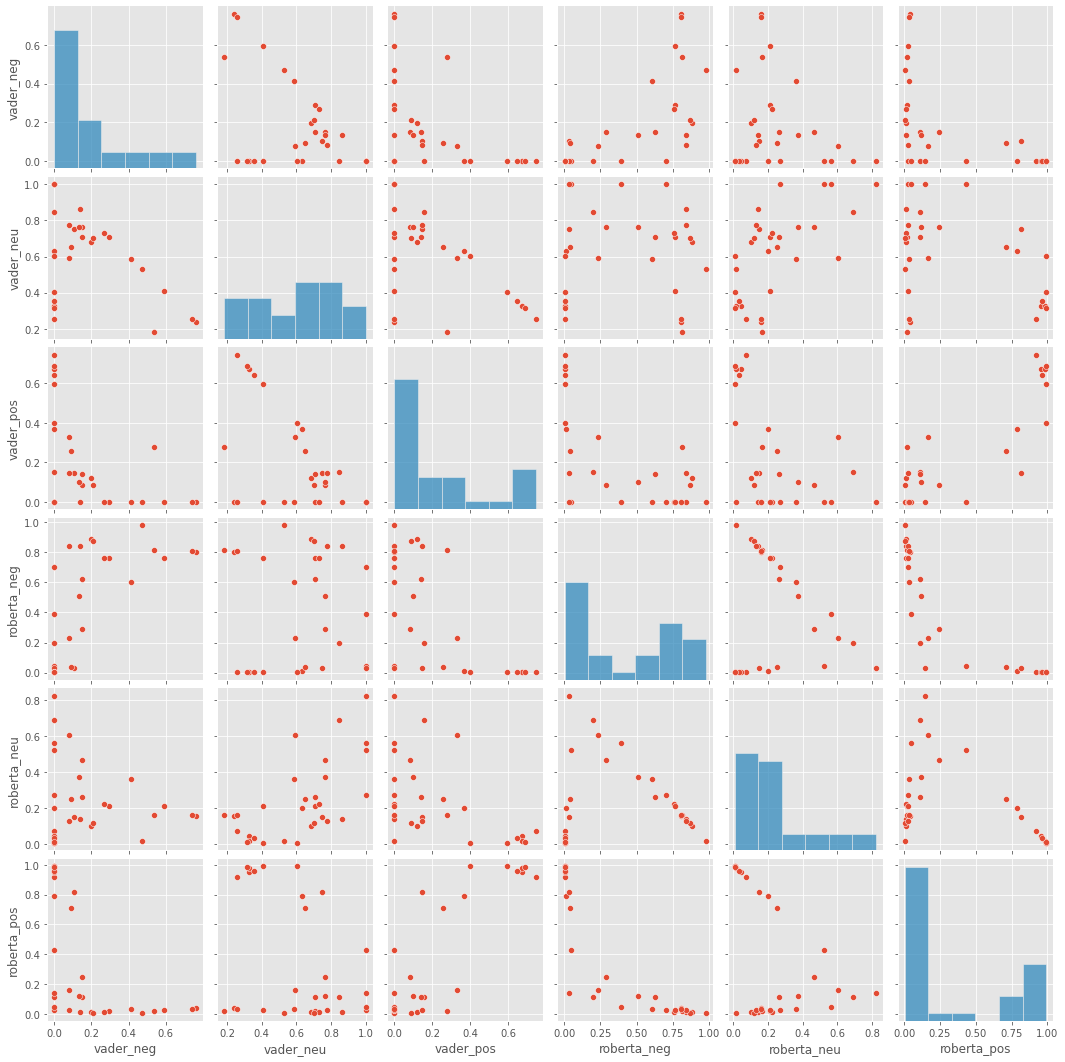

In [24]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            #hue='Score',
            palette='tab10')
plt.show()

In [25]:
#https://towardsdev.com/sentiment-model-deployment-efa0900735ee

In [45]:
import gzip
import dill

In [ ]:
#write the trained model into dill file
with gzip.open('sentimental_model.dill.gz', 'wb') as f:
    dill.dump(model, f, recurse=True)

In [46]:
#read the trained model from the dill file
with gzip.open('sentimental_model.dill.gz', 'rb') as f:
    model = dill.load(f)

In [47]:
model

In [48]:
encoded_text = tokenizer(example, return_tensors='tf')
output = model(**encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(example)
print(scores_dict)

Very week and feeling tired after metformin Level dropped dramatically late afternoon 
{'roberta_neg': 0.886625, 'roberta_neu': 0.102958344, 'roberta_pos': 0.010416527}


In [49]:
import gzip, dill
from flask import Flask, request, render_template, redirect
app = Flask(__name__) 
@app.route('/')
def main():
    return redirect('/index')
@app.route('/index', methods=['GET'])
def index():
    return render_template('index.html')
@app.route('/about')
def about():
    return "this is page is all about my ML model"
@app.route('/predict', methods=['GET', 'POST'])
def predict():
    if request.method == 'GET':
        tweet = request.args.get('tweet')
    else:
        tweet = request.form['text']
    
    with gzip.open("sentimental_model.dill.gz", 'rb') as f:
        model = dill.load(f)
        
    proba = model.predict_proba([tweet])[0,1] #it's will return two columns, index 0 is negative index 1 is positive
    return "positive sentiment: {}".format(proba)
    
    
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Sep/2022 10:00:46] "GET / HTTP/1.1" 302 -
[2022-09-19 10:00:46,317] ERROR in app: Exception on /index [GET]
Traceback (most recent call last):
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\STPI0560\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return

In [ ]:
<!DOCTYPE html>
<html>
    <head>
        <meta charset="utf-8">
        <title>Sentiment Analysis Model</title>
        
    </head>
    <body>
        <h1>Text Sentiment Analysis</h1>
        <h2>Enter Sentences</h2>
        <form id="input" method='post' action='predict'>
            <input type="text" name="text" value="your text here"
                   style="width:300px ; height:100px"/> <br>
            <input type="submit" value="Submit">
        </form>
    </body>
</html>

In [ ]:
#https://medium.com/@rtkilian/deploy-and-share-your-sentiment-analysis-app-using-streamlit-sharing-2ba3ca6a3ead

In [50]:
import streamlit as st
from transformers import pipeline

In [51]:
st.title('Sentiment Analyser App')
st.write('Welcome to my sentiment analysis app!')

2022-09-19 10:13:11.526 
  command:

    streamlit run C:\Users\STPI0560\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
